In [1]:
%matplotlib inline
import numpy as np
from numpy.random.mtrand import RandomState
from reco_gym import Configuration
from agents import Agent
from scipy.misc import logsumexp
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy
from agents import OrganicUserEventCounterAgent, organic_user_count_args
from reco_gym.envs.session import OrganicSessions
from reco_gym.envs.context import DefaultContext
from reco_gym.envs.observation import Observation
from agents import RandomAgent, random_args



import pylab

from keras.utils import to_categorical
import gym, reco_gym
import numpy as np
# env_0_args is a dictionary of default parameters (i.e. number of products)
from reco_gym import env_1_args, Configuration

P=1000

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P/2

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# .reset() env before each episode (one episode per user).
env.reset()

Using TensorFlow backend.


In [2]:
pylab.rcParams['figure.figsize'] = 7, 7

In [3]:
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

In [4]:
U = 1000
#reco_log = env.generate_logs(U, agent=organic_counter_agent)
reco_log = env.generate_logs(U)
organic_reco_log = reco_log[reco_log['z']=='organic']

counts = np.zeros((U,P))

for u in range(U):
    counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

# counts ignores time, but otherwise produces a representation of the users interests    
# you can either factorize counts directly or instead look at the co_counts i.e.


counts_above_zero = 1.*(counts>0) # above zero counts only

co_counts = np.matmul(counts_above_zero.T,counts_above_zero)


In [5]:
# a product might be summarised by the P length vector of its co-counts, e.g. for product 0
#co_counts[0,:]

this methodology works, but it doesn't scale..  at Criteo we have one billion products.. try re-running the above with just a 1000 - the user vecotors become long and sparse and the co-counts matrix is also very sparse.  We can determine similarities only between the most popular products.  In order to make the product embeddings both much shorter than P and not sparse we can use matrix factorization models.  You can either factorize the count matrix above or the co_counts matrix.

In [6]:
w,v = np.linalg.eig(co_counts)
idx = np.argsort(w)[::-1] 
v=np.real(v[:,idx])
w=np.real(w[idx])

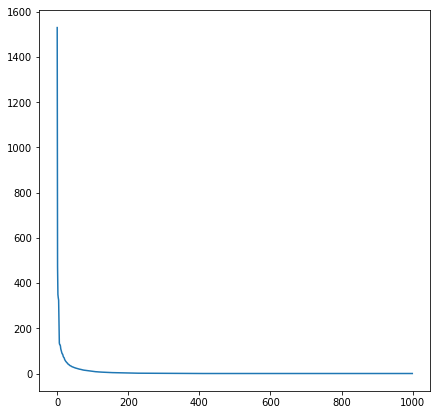

In [7]:
pylab.plot(w)

In [8]:
wdash = np.zeros_like(w)
K=5
wdash[0:K] = w[0:K]
embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:K] # keep the non-zero combonents

In [9]:
root=15
vvmax = ((np.matmul(embeddings,embeddings.T))).max()**(1/root)

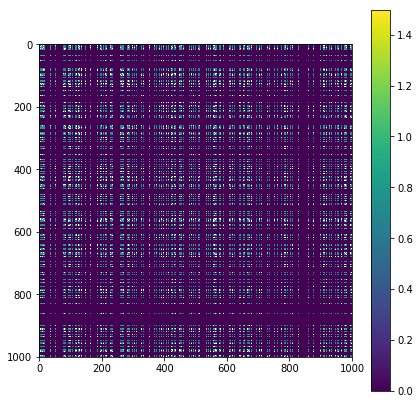

In [10]:
pylab.imshow((np.matmul(embeddings,embeddings.T))**(1/root),vmin=0,vmax=vvmax)
pylab.colorbar()

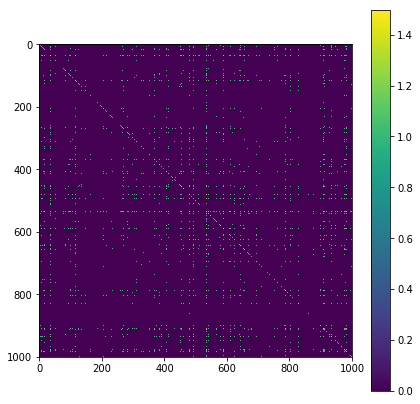

In [11]:
pylab.imshow((co_counts)**(1/root),vmin=0,vmax=vvmax)
pylab.colorbar()

the reason that the eigenvalue decomp is more full is that due to being a low-rank approximation it will be able to use logic such as if prodocut 0 is related to product 1 and product 1 is related to product 2 then product 0 is related to product 2

Text(0,0.5,'log embedding dot product')

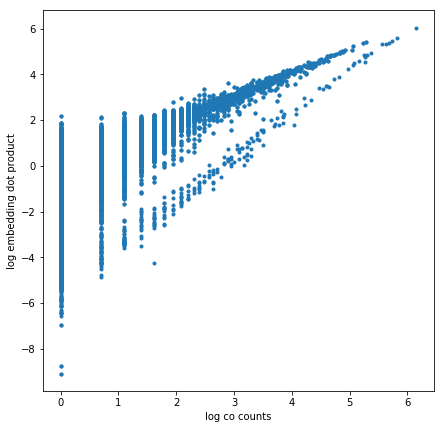

In [12]:
pylab.plot(np.log(co_counts.flatten()),np.log((np.matmul(embeddings,embeddings.T)).flatten()),'.')
pylab.xlabel('log co counts')
pylab.ylabel('log embedding dot product')

In [13]:
def create_embeddings(reco_log, K=5):
    organic_reco_log = reco_log[reco_log['z']=='organic']
    counts = np.zeros((U,P))

    for u in range(U):
        counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

    counts_above_zero = 1.*(counts>0) # above zero counts only
    co_counts = np.matmul(counts_above_zero.T,counts_above_zero)

    wdash = np.zeros_like(w)

    wdash[0:K] = w[0:K]
    embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:K] # keep the non-zero combonents        
    return embeddings

class AgentFromLog(Agent):
    def __init__(self, config, reco_log, K=5):
        super(AgentFromLog, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.organic_views = np.zeros(self.config.num_products)
        self.embeddings = create_embeddings(reco_log, K)
        self.K = K
        self.history_length = 0
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_embedding += self.embeddings[session['v'],:]
            self.history_length += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        uprob = np.matmul(self.embeddings,self.user_embedding/self.history_length)
        prob = np.exp(uprob-logsumexp(uprob))
        action = self.rng.choice(self.config.num_products, p = prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_embedding = np.zeros(self.K)
        self.history_length = 0

In [14]:
embedding_agent5  = AgentFromLog(Configuration(env_1_args), reco_log,  5)

embedding_agent50 = AgentFromLog(Configuration(env_1_args), reco_log, 50)


random_args['num_products'] = P
agent_rand = RandomAgent(Configuration({**env_1_args, **random_args,}))

In [15]:
def evaluate_IPS(agent, reco_log):
    ee = []
    for u in range(max(reco_log.u)):
        t = np.array(reco_log[reco_log['u']==u].t)
        v = np.array(reco_log[reco_log['u']==u].v)
        a = np.array(reco_log[reco_log['u']==u].a)
        c = np.array(reco_log[reco_log['u']==u].c)
        z = list(reco_log[reco_log['u']==u].z)
        ps = np.array(reco_log[reco_log['u']==u].ps)

        jj=0
        
        session = OrganicSessions()
        agent.reset()
        while True:
            if jj >= len(z):
                break
            if z[jj] == 'organic':
                session.next(DefaultContext(t[jj],u), int(v[jj]))
            else:
                prob_policy = agent.act(Observation(DefaultContext(t[jj],u), session), 0, False)['ps-a']
                ee.append(c[jj] * prob_policy[int(a[jj])] / ps[jj])
                session = OrganicSessions()
            jj += 1
    return ee

In [16]:
def verify_agents_IPS(reco_log, agents):
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    for agent_id in agents:
        ee = evaluate_IPS(agents[agent_id], reco_log)
        mean_ee = np.mean(ee)
        se_ee = np.std(ee)/np.sqrt(len(ee))
        stat['Agent'].append(agent_id)
        stat['0.025'].append(mean_ee - 2*se_ee)
        stat['0.500'].append(mean_ee)
        stat['0.975'].append(mean_ee + 2*se_ee)
    return pd.DataFrame().from_dict(stat)

In [17]:
verify_agents_IPS(reco_log, {'embedding_agent5': embedding_agent5, 'embedding_agent50': embedding_agent50, 'organic counter': organic_counter_agent, 'agent_rand': agent_rand})

,0.025,0.500,0.975,Agent
0,-0.013116,0.013132,0.039379,embedding_agent5
1,-0.013117,0.013131,0.039378,embedding_agent50
2,-0.008148,0.018547,0.045242,organic counter
3,0.009482,0.010210,0.010939,agent_rand


In [18]:
def verify_agents(env, number_of_users, agents):
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    for agent_id in agents:
        stat['Agent'].append(agent_id)
        data = deepcopy(env).generate_logs(number_of_users, agents[agent_id])
        bandits = data[data['z'] == 'bandit']
        successes = bandits[bandits['c'] == 1].shape[0]
        failures = bandits[bandits['c'] == 0].shape[0]
        stat['0.025'].append(beta.ppf(0.025, successes + 1, failures + 1))
        stat['0.500'].append(beta.ppf(0.500, successes + 1, failures + 1))
        stat['0.975'].append(beta.ppf(0.975, successes + 1, failures + 1))
        
    return pd.DataFrame().from_dict(stat)

In [19]:
verify_agents(env, U, {'embedding_agent5': embedding_agent5, 'embedding_agent50': embedding_agent50, 'organic counter': organic_counter_agent, 'agent_rand': agent_rand})

,0.025,0.500,0.975,Agent
0,0.012812,0.013614,0.014449,embedding_agent5
1,0.013944,0.014784,0.015657,embedding_agent50
2,0.014651,0.015520,0.016421,organic counter
3,0.010508,0.011242,0.012008,agent_rand
